In [2]:
import statsmodels.api as sm
import cabi.etl.load as l
import cabi.etl.transform as t
import cabi.viz as v
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from statsmodels.tsa.deterministic import DeterministicProcess
from pandas import date_range
from statsmodels.tsa.deterministic import Fourier
index = date_range("2000-1-1", freq="D", periods=5000)
fourier = Fourier(period=365.25, order=1)
dp = DeterministicProcess(index, period=3, constant=True,
                              seasonal=True, additional_terms=[fourier])
dp.in_sample()


,const,"s(2,3)","s(3,3)","sin(1,365.25)","cos(1,365.25)"
2000-01-01,1.0,0.0,0.0,0.000000,1.000000
2000-01-02,1.0,1.0,0.0,0.017202,0.999852
2000-01-03,1.0,0.0,1.0,0.034398,0.999408
2000-01-04,1.0,0.0,0.0,0.051584,0.998669
2000-01-05,1.0,1.0,0.0,0.068755,0.997634
...,...,...,...,...,...
2013-09-04,1.0,0.0,0.0,-0.892612,-0.450826
2013-09-05,1.0,1.0,0.0,-0.900235,-0.435405
2013-09-06,1.0,0.0,1.0,-0.907591,-0.419855
2013-09-07,1.0,0.0,0.0,-0.914679,-0.404181


In [10]:
vals = dp.in_sample()
vals.loc['2004-01-01']

const            1.000000e+00
s(2,3)           0.000000e+00
s(3,3)           0.000000e+00
sin(1,365.25)   -9.797174e-16
cos(1,365.25)    1.000000e+00
Name: 2004-01-01 00:00:00, dtype: float64

In [11]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [12]:
series = l.load_counts('2A')

In [13]:
six_hours2A = t.cumulative_change(series, '6H')

In [14]:
hourly2A = t.series_to_interval(six_hours2A, '1H')

In [18]:
hourly2A.interpolate('time', inplace=True)

<AxesSubplot:xlabel='time'>

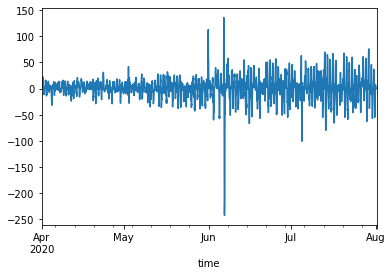

In [19]:
hourly2A.plot()

## Note the large outliers coincident with the George Floyd Protests, a band-pass or other filter may be warranted 

The Variance appears to increase substantially after this major imbalancing event, indicating it may not have fully recovered or that the event is ongoing to a lesser degree, would be worth looking at the relative variance from prior years same period

Working theory: more variance is actually normal and apr/may were covid suppressed volumes.

<AxesSubplot:xlabel='time'>

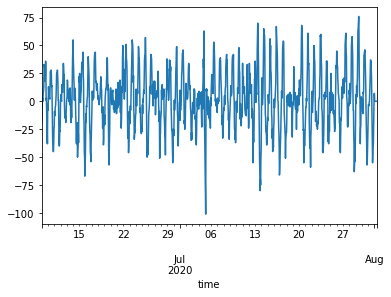

In [20]:
hourly2A[hourly2A.index >= '2020-06-09'].plot()

In [21]:
jun_aug = hourly2A[hourly2A.index >= '2020-06-09']

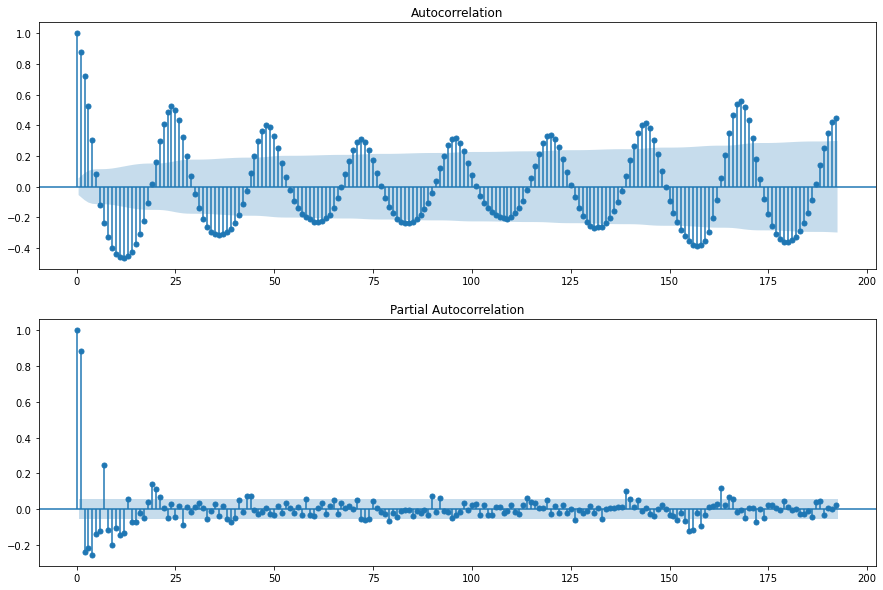

In [25]:
v.plot_acf_pacf(jun_aug,192)

In [20]:
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

In [27]:
train, test = jun_aug[:-168], jun_aug[-168:]

In [28]:
mod_markov = MarkovAutoregression(train, k_regimes=2, order=4, switching_variance=True)

In [29]:
res_markov = mod_markov.fit()

In [30]:
res_markov.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                       2A   No. Observations:                 1109
Model:             MarkovAutoregression   Log Likelihood               -4230.569
Date:                  Sun, 06 Sep 2020   AIC                           8489.139
Time:                          16:15:46   BIC                           8559.296
Sample:                      06-09-2020   HQIC                          8515.669
                           - 07-25-2020                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9213      2.335     -0.823      0.411      -6.498       2.655
sigma2       254.6238     56.967      4.470      0.000     142.971     366.276
ar.L1          0.3000      0.116      2.590      0.010       0.073       0.527
ar.L2         -0.1377      0.138     -0.996      0.319      -0.409       0.133
ar.L3          0.1985      0.158      1.256      0.209      -0.111       0.508
ar.L4         -0.2888      0.137     -2.108      0.035      -0.557      -0.020
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8261      1.509      1.210      0.226      -1.131       4.783
sigma2        94.0099      6.282     14.964      0.000      81.697     106.323
ar.L1          1.0239      0.034     29.838      0.000       0.957       1.091
ar.L2          0.0151      0.051      0.299      0.765      -0.084       0.114
ar.L3         -0.0016      0.047     -0.034      0.973      -0.093       0.090
ar.L4         -0.2253      0.033     -6.864      0.000      -0.290      -0.161
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5917      0.123      4.816      0.000       0.351       0.832
p[1->0]        0.0424      0.013      3.141      0.002       0.016       0.069
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [34]:
preds= res_markov.predict(start=len(train), end=len(train)+168)

NotImplementedError: 

<AxesSubplot:xlabel='time'>

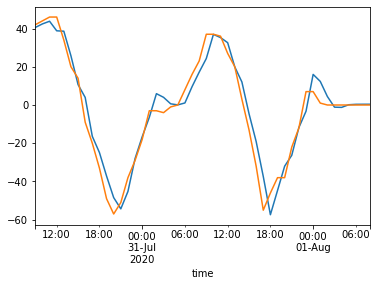

In [37]:
predds[-48:].plot()
jun_aug[-48:].plot()

In [36]:
RMSE(test[-168:], predds[-168:])

9.700336614201802

<AxesSubplot:xlabel='time'>

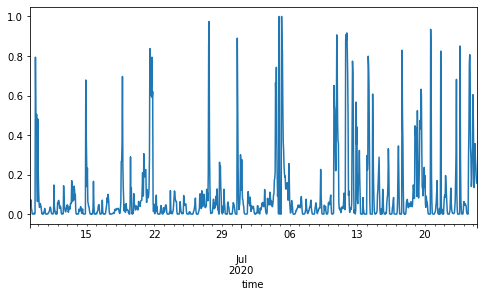

In [39]:
res_markov.smoothed_marginal_probabilities[0].plot(figsize=(8,4))

### The Issue To Solve:

We have a number of different ways to come up with a decent model of the general pattern where there is daily seasonal effect, with the last few hours lag being a substantial predictor of the next period. However, there are two major things we would like to capture that we have so far been unable to:

    1. The Jagged Period from around midnight thru the start of the morning: the lag coefficients don't follow the same pattern that they do for the rest of the day. We,d like to either counterweight them or do some form of conditional filtering. One method could be an exogenous hour of the day column.
    2. The increased variance during the weekend. The size of the seasonal cycle is temporarily bigger here. A markov regime switching appproach could be useful as demonstrated above, but statsmodels does not support out of sample predictions for this type of model.
    

### A Possible Solution (we hope):

We will explore representing seasonality exogenously through fourier process and some form of VARMAX, as well as time varying regression. Another notebook looks at using pmdarima pipelines with a PowerTransform (box cox), but we have so far been unable to solve the compatibility issues between latest release of statsmodels and pmdarima or implement a similar approach with sklearn pipelines.

## SARIMAX with time varying regression

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [42]:
train, test = jun_aug[:-168], jun_aug[-168:]

sari_vari = SARIMAX(train, order=(5,0,0), seasonal_order=(2,1,0,24),
                   time_varying_regression=True, mle_regression=False)

In [43]:
sari_vari_res = sari_vari.fit()

In [44]:
sari_vari_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 2A   No. Observations:                 1113
Model:             SARIMAX(5, 0, 0)x(2, 1, 0, 24)   Log Likelihood               -4265.153
Date:                            Sun, 06 Sep 2020   AIC                           8546.307
Time:                                    18:41:30   BIC                           8586.251
Sample:                                06-09-2020   HQIC                          8561.425
                                     - 07-25-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8377      0.026     31.683      0.000       0.786       0.889
ar.L2          0.0115      0.037      0.308      0.758      -0.062       0.085
ar.L3          0.0836      0.037      2.241      0.025       0.010       0.157
ar.L4         -0.0747      0.039     -1.930      0.054      -0.151       0.001
ar.L5         -0.1456      0.028     -5.175      0.000      -0.201      -0.090
ar.S.L24      -0.6210      0.023    -26.968      0.000      -0.666      -0.576
ar.S.L48      -0.3020      0.026    -11.750      0.000      -0.352      -0.252
sigma2       146.0633      5.194     28.124      0.000     135.884     156.243
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               161.56
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.03
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
sari_preds = sari_vari_res.predict(start=test.index[0], end=test.index[-1])

In [46]:
RMSE(test, sari_preds)

22.68178365564716

<AxesSubplot:xlabel='time'>

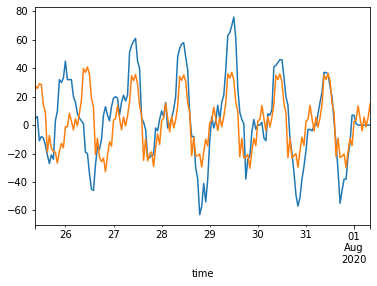

In [48]:
test.plot()
sari_preds.plot()

In [66]:
sari_vari_2 = SARIMAX(train, order=((1,0,1,1,1),0,0), trend='n', seasonal_order=(2,1,0,24),
                   time_varying_regression=True, mle_regression=False)

In [67]:
sari_vari_res2 = sari_vari_2.fit()

In [68]:
sari_vari_res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                            2A   No. Observations:                 1113
Model:             SARIMAX([1, 3, 4, 5], 0, 0)x(2, 1, 0, 24)   Log Likelihood               -4265.196
Date:                                       Sun, 06 Sep 2020   AIC                           8544.391
Time:                                               19:05:10   BIC                           8579.342
Sample:                                           06-09-2020   HQIC                          8557.620
                                                - 07-25-2020                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8434      0.019     44.080      0.000       0.806       0.881
ar.L3          0.0893      0.033      2.740      0.006       0.025       0.153
ar.L4         -0.0752      0.039     -1.942      0.052      -0.151       0.001
ar.L5         -0.1450      0.028     -5.158      0.000      -0.200      -0.090
ar.S.L24      -0.6200      0.023    -26.954      0.000      -0.665      -0.575
ar.S.L48      -0.3018      0.026    -11.747      0.000      -0.352      -0.251
sigma2       146.0783      5.194     28.123      0.000     135.898     156.259
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):               162.07
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.03
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
sari_preds2 = sari_vari_res2.predict(start=train.index[-24], end=test.index[-1])

<AxesSubplot:xlabel='time'>

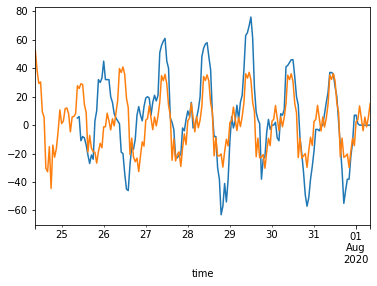

In [70]:
test.plot()
sari_preds2.plot()

In [ ]:

dp = DeterministicProcess(test.index, period=24,
                              seasonal=True, additional_terms=[fourier])

dp.in_sample()

In [77]:
import numpy as np
import pandas as pd
base = pd.Timestamp("2020-1-1")
gen = np.random.default_rng()
gaps = np.cumsum(gen.integers(0, 1800, size=1000))
times = [base + pd.Timedelta(gap, unit="s") for gap in gaps]
index = jun_aug.index
from statsmodels.tsa.deterministic import CalendarSeasonality
cal_seas_gen = CalendarSeasonality("H", "D")
dummies = cal_seas_gen.in_sample(index)

In [78]:
train_exog = dummies[dummies.index.isin(train.index)]

In [79]:
test_exog = dummies[dummies.index.isin(test.index)]
test_exog

,"s(H=1, period=D)","s(H=2, period=D)","s(H=3, period=D)","s(H=4, period=D)","s(H=5, period=D)","s(H=6, period=D)","s(H=7, period=D)","s(H=8, period=D)","s(H=9, period=D)","s(H=10, period=D)",...,"s(H=15, period=D)","s(H=16, period=D)","s(H=17, period=D)","s(H=18, period=D)","s(H=19, period=D)","s(H=20, period=D)","s(H=21, period=D)","s(H=22, period=D)","s(H=23, period=D)","s(H=24, period=D)"
time,,,,,,,,,,,,,,,,,,,,,
2020-07-25 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-25 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-25 11:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-25 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-25 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01 04:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-01 05:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
sari_vari_3 = SARIMAX(train, order=((1,0,1,1,1),0,0), trend='c', seasonal_order=(2,1,0,24),
                     exog=train_exog)

In [81]:
%%time
sari_vari_res3 = sari_vari_3.fit()

CPU times: user 8min 14s, sys: 4.01 s, total: 8min 18s
Wall time: 1min 2s


In [82]:
sari_vari_res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                            2A   No. Observations:                 1113
Model:             SARIMAX([1, 3, 4, 5], 0, 0)x(2, 1, 0, 24)   Log Likelihood               -4265.195
Date:                                       Sun, 06 Sep 2020   AIC                           8594.391
Time:                                               19:42:26   BIC                           8754.167
Sample:                                           06-09-2020   HQIC                          8654.865
                                                - 07-25-2020                                         
Covariance Type:                                         opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0063      0.374      0.017      0.987      -0.726       0.739
s(H=1, period=D)   7.091e-07   9.05e+04   7.84e-12      1.000   -1.77e+05    1.77e+05
s(H=2, period=D)    9.92e-07   7.67e+04   1.29e-11      1.000    -1.5e+05     1.5e+05
s(H=3, period=D)   6.701e-07   9.35e+04   7.17e-12      1.000   -1.83e+05    1.83e+05
s(H=4, period=D)  -4.773e-07   4.43e+04  -1.08e-11      1.000   -8.68e+04    8.68e+04
s(H=5, period=D)  -9.778e-08   3.81e+04  -2.56e-12      1.000   -7.47e+04    7.47e+04
s(H=6, period=D)  -9.523e-07    4.5e+04  -2.11e-11      1.000   -8.83e+04    8.83e+04
s(H=7, period=D)  -1.124e-06   5.67e+04  -1.98e-11      1.000   -1.11e+05    1.11e+05
s(H=8, period=D)  -1.013e-06    7.8e+04   -1.3e-11      1.000   -1.53e+05    1.53e+05
s(H=9, period=D)   2.399e-07   8.12e+04   2.95e-12      1.000   -1.59e+05    1.59e+05
s(H=10, period=D) -1.186e-06   9.19e+04  -1.29e-11      1.000    -1.8e+05     1.8e+05
s(H=11, period=D)  -6.43e-07   7.47e+04  -8.61e-12      1.000   -1.46e+05    1.46e+05
s(H=12, period=D) -1.212e-06   5.74e+04  -2.11e-11      1.000   -1.12e+05    1.12e+05
s(H=13, period=D) -2.119e-07   6.63e+04  -3.19e-12      1.000    -1.3e+05     1.3e+05
s(H=14, period=D)  1.516e-06   1.42e+05   1.06e-11      1.000   -2.79e+05    2.79e+05
s(H=15, period=D) -7.241e-07   1.39e+05  -5.22e-12      1.000   -2.72e+05    2.72e+05
s(H=16, period=D) -4.152e-06    1.4e+05  -2.96e-11      1.000   -2.75e+05    2.75e+05
s(H=17, period=D) -4.385e-06   7.74e+04  -5.67e-11      1.000   -1.52e+05    1.52e+05
s(H=18, period=D)  -2.23e-06   9.97e+04  -2.24e-11      1.000   -1.95e+05    1.95e+05
s(H=19, period=D) -6.719e-06   7.93e+04  -8.47e-11      1.000   -1.55e+05    1.55e+05
s(H=20, period=D) -5.452e-06   7.37e+04   -7.4e-11      1.000   -1.44e+05    1.44e+05
s(H=21, period=D) -1.843e-06   1.82e+05  -1.01e-11      1.000   -3.57e+05    3.57e+05
s(H=22, period=D) -3.059e-06   1.34e+05  -2.28e-11      1.000   -2.63e+05    2.63e+05
s(H=23, period=D) -1.125e-06   1.31e+05  -8.61e-12      1.000   -2.56e+05    2.56e+05
s(H=24, period=D) -5.726e-06    9.8e+04  -5.84e-11      1.000   -1.92e+05    1.92e+05
ar.L1                 0.8434      0.019     43.903      0.000       0.806       0.881
ar.L3                 0.0893      0.033      2.712      0.007       0.025       0.154
ar.L4                -0.0752      0.039     -1.931      0.053      -0.151       0.001
ar.L5                -0.1450      0.028     -5.137      0.000      -0.200      -0.090
ar.S.L24             -0.6200      0.023    -26.876      0.000      -0.665      -0.575
ar.S.L48             -0.3018      0.026    -11.717      0.000      -0.352      -0.251
sigma2              146.0829      5.220     27.985      0.000     135.852     156.314
========================

In [87]:
sari_preds3 = sari_vari_res3.predict(start=train.index[0], dynamic=test.index[0], end=test.index[-1], exog=test_exog)

<AxesSubplot:xlabel='time'>

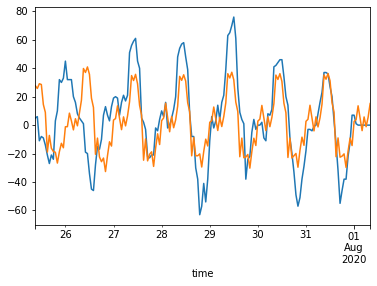

In [89]:
test.plot()
sari_preds3[-168:].plot()

In [91]:
test.sort_values(ascending=False).head(30)

time
2020-07-29 12:00:00    76.0
2020-07-29 11:00:00    70.0
2020-07-29 10:00:00    65.0
2020-07-29 09:00:00    63.0
2020-07-29 13:00:00    61.0
2020-07-27 11:00:00    61.0
2020-07-27 10:00:00    59.0
2020-07-28 11:00:00    58.0
2020-07-28 10:00:00    57.0
2020-07-27 09:00:00    56.0
2020-07-28 09:00:00    54.0
2020-07-27 08:00:00    51.0
2020-07-28 08:00:00    48.0
2020-07-28 12:00:00    48.0
2020-07-30 12:00:00    46.0
2020-07-30 11:00:00    46.0
2020-07-27 12:00:00    45.0
2020-07-26 00:00:00    45.0
2020-07-30 10:00:00    44.0
2020-07-30 09:00:00    42.0
2020-07-30 08:00:00    41.0
2020-07-27 13:00:00    40.0
2020-07-28 13:00:00    39.0
2020-07-29 08:00:00    39.0
2020-07-31 10:00:00    37.0
2020-07-31 09:00:00    37.0
2020-07-31 11:00:00    36.0
2020-07-30 13:00:00    34.0
2020-07-25 23:00:00    33.0
2020-07-26 02:00:00    32.0
Name: 2A, dtype: float64

In [ ]:
import pmdarima as pm
from pmdarima import arima
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing as ppc


from statsmodels.tsa.regime_switching.markov_autoregression import


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer


import cabi.etl.load as l
import cabi.etl.transform as t

